In [0]:
import sys
sys.path.append("/content/gdrive/My Drive/TrafficSign/8class/")
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**labelmap is a map to reduce 43 class to 8 class. (you can see 8 class in class.names)**

In [0]:
labelmap = { "0": "0",
  "1": "0",
  "2": "0",
  "3": "0",
  "4": "0",
  "5": "0",
  "6": "6",
  "7": "0",
  "8": "0",
  "9": "0",
  "10": "0",
  "11": "1",
  "12": "2",
  "13": "3",
  "14": "4",
  "15": "0",
  "16": "0",
  "17": "5",
  "18": "1",
  "19": "1",
  "20": "1",
  "21": "1",
  "22": "1",
  "23": "1",
  "24": "1",
  "25": "1",
  "26": "1",
  "27": "1",
  "28": "1",
  "29": "1",
  "30": "1",
  "31": "1",
  "32": "6",
  "33": "7",
  "34": "7",
  "35": "7",
  "36": "7",
  "37": "7",
  "38": "7",
  "39": "7",
  "40": "7",
  "41": "6",
  "42": "6"}

**histogram and class-path dictionary are found. img_path[8class, which_path_has_this class]**

In [0]:
path ='/content/gdrive/My Drive/TrafficSign/8class/'
with open(path + 'gt.txt','r') as f:
  lines = f.readlines()
trainpaths = [line.rstrip('\n') for line in open(path + 'train.txt')]

hist = {}
bbox = {}
img_path = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': []}
for i, line in enumerate(lines):
  line = line.replace("\n", "")
  x = line.split(";")
  l = labelmap[x[5]]
  x_0 = (path + "images/" + x[0].replace("ppm", "jpg"))
  
  if(x_0 in trainpaths):    
    if(x_0 not in bbox):
      bbox[x_0] = [[float(x[1]),float(x[2]),float(x[3]),float(x[4]),float(l)]]
    else:
      bbox[x_0].append([float(x[1]),float(x[2]),float(x[3]),float(x[4]),float(l)])
    hist[l] = hist.get(l, 0) + 1
    if(x_0 not in img_path[l]):
      img_path[l].append(x_0)


**Since ground truth represents corner points and yolo wants the center of bounding box, convert function calculates the center of bounding box.

*   **Since ground truth represents corner points and yolo wants the center of bounding box, convert function calculates the center of bounding box.**
*   **Save function saved the images into target path (aug_images)**
*   **While loop creates augmented images from images with less number, until it reaches maximum number(class with maximum number)**
*   **Augmentation techniques are RandomFlip, RandomRotate, RandomHSV etc.**






In [0]:
import random
from PIL import Image

def convert(size,box):

  left_x = float(box[0]) / size[0]
  bottom_y = float(box[1]) / size[1]
  right_x = float(box[2]) / size[0]
  top_y = float(box[3]) / size[1]

  object_width = right_x - left_x
  object_height = top_y - bottom_y
  object_mid_x = (left_x + right_x) / 2.0
  object_mid_y = (bottom_y + top_y) / 2.0

  return (object_mid_x, object_mid_y, object_width, object_height)

def save(img, box, name):  
  outfile = open('/content/gdrive/My Drive/TrafficSign/8class/aug_images/' + name + '.txt', 'w')
  img = Image.fromarray(img, 'RGB')
  img.save(path +"aug_images/" + name + ".jpg")

  for filepath in box:
    bb = convert(img.size, (filepath[0],filepath[1],filepath[2],filepath[3]))
    info = str(int(filepath[4])) +" "+" ".join([str(a) for a in bb]) + '\n'
    outfile.write(info)
  outfile.close()

name = 0
for i in range(1,8):
  j=0
  while(j<len(img_path['0'])):
    for k in range(len(img_path[str(i)])):
      img = cv2.imread(img_path[str(i)][k])[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
      bboxes = bbox[img_path[str(i)][k]]
      bboxes = np.array(bboxes)
      name += 1
      save(img, bboxes, str(name).zfill(5))
      if(name == 10):
        print(name, bboxes)
      value = random.uniform(0, 1)
      img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))

      value = random.uniform(0, 1)
      img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))

      value = random.uniform(0, 1)
      img_, bboxes_ = RandomTranslate(0.3, diff = True)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))

      v = random.randint(0, 360)
      img_, bboxes_ = RandomRotate(v)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))

      value = random.uniform(0, 1)
      img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))

      value = random.randint(384, 1024)
      img_, bboxes_ = Resize(value)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))

      v1, v2, v3 = random.randint(0, 256), random.randint(0, 256), random.randint(0, 256)
      img_, bboxes_ = RandomHSV(v1, v2, v3)(img.copy(), bboxes.copy())
      name += 1
      save(img_, bboxes_, str(name).zfill(5))
      
      try:
        seq = Sequence([RandomHSV(v1, v2, v3),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(v), RandomShear()])
        img_, bboxes_ = seq(img.copy(), bboxes.copy())
        name += 1
        save(img_, bboxes_, str(name).zfill(5))
      except:
        print("Error occured!")

      j+=8



** Examples of some augmentation techniques on sample images**

In [0]:
img = cv2.imread(img_path['1'][0])[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = bbox[img_path['1'][0]]
#inspect the bounding boxes
print(bboxes)

[[774.0, 411.0, 815.0, 446.0, 1.0]]


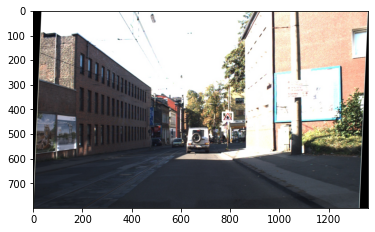

In [0]:
from PIL import Image
plotted_img = draw_rect(img_, bboxes_)
img = Image.fromarray(plotted_img, 'RGB')

img.save(path +"aug_images/0.jpg")
plt.imshow(plotted_img)
plt.show()

In [0]:
np.array(bboxes)

array([[774., 411., 815., 446.,   1.]])

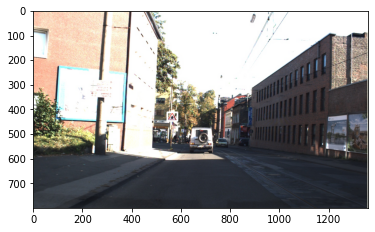

In [0]:

img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), np.array(bboxes).copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

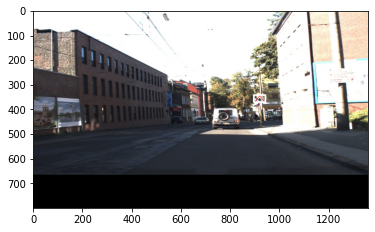

In [0]:
img_, bboxes_ = RandomScale(0.3, diff = True)(img.copy(), np.array(bboxes).copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

In [0]:
bboxes_

array([[769.88610801, 411.        , 810.81676186, 446.        ,
          1.        ]])

In [0]:
outfile = open('/content/gdrive/My Drive/TrafficSign/8class/aug_images/train.txt', 'w')
def convert(size,box):

  left_x = float(box[0]) / size[0]
  bottom_y = float(box[1]) / size[1]
  right_x = float(box[2]) / size[0]
  top_y = float(box[3]) / size[1]

  object_width = right_x - left_x
  object_height = top_y - bottom_y
  object_mid_x = (left_x + right_x) / 2.0
  object_mid_y = (bottom_y + top_y) / 2.0
  return (object_mid_x, object_mid_y, object_width, object_height)

for filepath in bboxes_:
  print(filepath)
  bb = convert((2024,2024), (filepath[0],filepath[1],filepath[2],filepath[3]))
  print(int(filepath[4]))
  info = str(int(filepath[4])) +" "+" ".join([str(a) for a in bb]) + '\n'
  print(info)
  outfile.write(info)
outfile.close()
